# Defining relevant functions


In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.stats import laplace, norm
from typing import Callable

In [2]:
def arbitrary_poly(params: list) -> Callable:
    """
    Takes the parameters in params and makes them into a polynomial 
        theta_0 + theta_1*x + theta_2*x^2 + ... + theta_n*x^n
    where n is model order and theta_0 is bias. 
    Args:
        params: list on format [theta_0, theta_1, theta_2, ..., theta_n]
    Returns:
        Function with single argument x. 
    """
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model


In [3]:
class GaussParams:
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std
        self.var = std**2

        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.std

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.std))


class LaplaceParams:
    def __init__(self, mean: float, beta: float):
        self.mean = mean
        self.beta = beta
        
        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.beta

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.beta))


In [4]:
def generate_noise(
        N: int, 
        magnitude: float, 
        alpha: float, 
        gauss_params: GaussParams, 
        laplace_params: LaplaceParams, 
        seed: int = None
    ) -> np.ndarray:
    """
    Generate noise based on the mixture model: alpha * gaussian + (1 - alpha) * laplacian.
    Args:
        N: number of noise points to generate.
        magnitude: the noise amplitude/magnitude.
        alpha: probabilty of guassian or laplacian, should be in interval [0, 1].
        gauss_params: mean and std of gaussian distribution
        laplace_params: mean and beta of laplacian distribution
        seed: a custom seed to the RNG. If None, the RNG is not seeded.
    Returns:
        A list of N noise points.
    """
    if seed is not None:
        np.random.seed(seed)

    if alpha == 1:
        assert gauss_params is not None
        noise = np.random.normal(*gauss_params, N)
    elif alpha == 0:
        assert laplace_params is not None
        noise = np.random.laplace(*laplace_params, N)
    else:
        assert gauss_params is not None
        assert laplace_params is not None
        assert 0 < alpha < 1
        noise = np.zeros((N,))
        for i in range(N):
            r = np.random.uniform(0,1)
            if r <= alpha:
                noise[i] = np.random.normal(*gauss_params)
            else:
                noise[i] = np.random.laplace(*laplace_params)
    noise *= magnitude

    return noise

In [5]:
def add_outliers(y: np.ndarray, gamma: float, outlier_ampl: float = 100, seed: int = None) -> np.ndarray:
    """
    Adds outliers to y with probabilty gamma.
    Args:
        y: an array of measurement values with or without noise, shape = (N,) or (N,1).
        gamma: probability of a specific measurement being an outlier.
        outlier_ampl: amplitude of outlier, default 100.
        seed: custom seed to RNG. If None, do not reseed RNG.
    Returns:
        y_outlier: an array of the same lengths as y, but with some added outliers.
    """
    if seed is not None:
        np.random.seed(seed)

    assert 0 <= gamma <= 1

    N = y.shape[0]
    y_outlier = np.copy(y)
    for i in range(N):
        r = np.random.uniform(0,1)
        if r <= gamma:
            y_outlier[i] = outlier_ampl

    return y_outlier


In [6]:
def least_square(u: np.ndarray, y: np.ndarray, n_params: int) -> np.ndarray:
    """
    Uses least sqaure (LS) to make the best fitting list of parameters.
    Args:
        u: data x values, shape = (N_samples,)
        y: data y values, shape = (N_samples,)
        n_params: number of parameters to find
    """
    N = u.shape[0]
    
    # Create data tensor
    u_tensor = np.ones((N,1))
    for i in range(1, n_params):
        u_tensor = np.append(u_tensor, np.power(u.reshape((-1,1)), i), axis=1)

    # Solve for LS params
    u_dot_u = u_tensor.T @ u_tensor
    u_dot_y = u_tensor.T @ y
    # linalg.solve is more numerically stable than linalg.inv and is therefore preferred
    ls_params = np.linalg.solve(u_dot_u, u_dot_y)

    return ls_params


In [7]:
def ls_statistics(
    u: np.ndarray,
    y: np.ndarray, 
    true_params: np.ndarray, 
    ls_params_estimate: np.ndarray) -> tuple:
    """
    Calculate statistics on LS performance. 
    Args:
        u: data points x value.
        y: measured data points (with noise).
        true_params: list of the true parameters.
        ls_params_estimate: list of the LS parameters estimates.
    Returns:
        Tuple on the form 
            (RMSE, d) 
        where d is the Euclidean distance between the true and estimated parameters.
    """
    ls_model = arbitrary_poly(ls_params_estimate)
    rmse = np.sqrt(np.mean( (ls_model(u) - y)**2 ))
    d = np.linalg.norm( ls_params_estimate - np.array(true_params) )

    return rmse, d


In [8]:
def sum_abs_deviation(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate the sub of absolute deviation between outputs y for each u.
    Args:
        u: data points x value.
        y: measurement data.
        est_params: estimate parameters from the data.
    Returns:
        sad: the sum of absolute deviation.
    """
    assert len(u) == len(y)

    y_est = arbitrary_poly(est_params)(u)
    sad = np.sum(np.abs(y - y_est))

    return sad

In [9]:
def log_likelihood(params: np.ndarray, u: np.ndarray, y: np.ndarray, pdf: Callable) -> np.float:
    """
    Computes the log-likelihood of the pdf given the data u and y.
    Args:
        params: the parameters for the model.
        u: data points x value.
        y: measurement data.
        pdf: pdf function from scipy of desired distribution.
    Returns:
        The log-likelihood of the pdf evaluated at the data, or np.inf.
    """
    if params[-1] < 0: 
        # standard deviation is estimated and cannot be negative
        return 1e9 # np.inf
    
    lik = pdf(y, loc=arbitrary_poly(params[:-1])(u), scale=params[-1])
    
    # log(0) = -inf
    if np.all(lik == 0):
        return 1e9 # np.inf

    ll = -np.sum(np.log(lik[np.nonzero(lik)]))
    return ll


def maximum_likelihood(u: np.ndarray, y: np.ndarray, n_params: int, pdf: Callable, opt_disp: bool = False) -> np.ndarray:
    """
    Calculates the Maximum Likelihood estimate for a polynomial model with n_params parameters
    based on the given pdf.
    Args:
        u: data points x values, shape = (N,).
        y: measurement data, shape = (N,).
        n_params: the number of parameters in the model, including bias. 
                  theta_0 + theta_1*x + theta_2*x^2 + ... + theta_n*x^n
        pdf: pdf function from scipy of desired distribution.
        opt_disp: show output from optimization function, default False.
    Returns:
        List of parameters. 
    """
    assert len(u) == len(y)
    
    N = u.shape[0]
    init_guess = np.zeros((n_params + 1,))
    init_guess[-1] = N

    optres = optimize.minimize(
        fun=log_likelihood, x0=init_guess, args=(u, y, pdf), options={"disp": opt_disp}
    )

    ml_params = optres.x[:-1]
    return ml_params


# Choosing model order and training model

## Generate data

In [10]:
# True model
true_params = [1,-8,4]
n_params = len(true_params)
y_model = arbitrary_poly(true_params)

# Hyperparameters for noise generation
magnitude = 1.2  # noise magnitude
N = 201          # number of samples

# Setup RNG
np.random.seed(0)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -3
range_high = 3

do_sorting = False
if do_sorting:
    u = np.sort(np.random.uniform(range_low, range_high, N))
else:
    u = np.random.uniform(range_low, range_high, N)

u_sorted = np.sort(u)  # only used for plotting
y_true = y_model(u)

# Generate noise
noise = generate_noise(N, magnitude, 0, None, LaplaceParams(0, 1), seed=None)
y_noise = y_true + noise

# Add outliers
gamma = 0.2
y_outlier = add_outliers(y_noise, gamma)

# Split into train, test and validate sets
M = N // 3  # size of each subset
u_train, y_train = u[0:M], y_outlier[0:M]
u_test, y_test = u[M:2*M], y_outlier[M:2*M]
u_val, y_val = u[2*M:3*M], y_outlier[2*M:3*M]

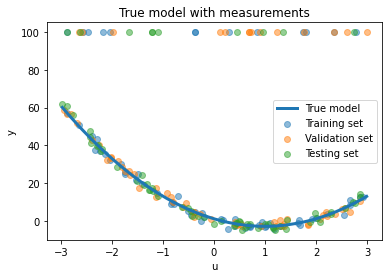

In [11]:
# Plot model and measurements
plt.figure()
plt.plot(u_sorted, y_model(u_sorted), lw=3, label="True model")
# plt.scatter(u, y_outlier, alpha=0.5, label="Measurements w/ outliers")
plt.scatter(u_train, y_train, alpha=0.5, label="Training set")
plt.scatter(u_val, y_val, alpha=0.5, label="Validation set")
plt.scatter(u_test, y_test, alpha=0.5, label="Testing set")
plt.legend()
plt.xlabel("u")
plt.ylabel("y")
plt.title("True model with measurements")
plt.show()


## Train affine/linear model

In [12]:
# LS
affine_ls = least_square(u_train, y_train, 2)
affine_ls_mod = arbitrary_poly(affine_ls)
print(affine_ls)

# LS performance
sad_affine_ls = sum_abs_deviation(u_val, y_val, affine_ls)
print(sad_affine_ls)

# ML
affine_ml = maximum_likelihood(u, y_outlier, 2, pdf=laplace.pdf)
affine_ml_mod = arbitrary_poly(affine_ml)
print(affine_ml)

# ML performance
sad_affine_ml = sum_abs_deviation(u_val, y_val, affine_ml)
print(sad_affine_ml)



[27.82781084 -7.00976856]
1928.6188888395127
[12.50025527 -8.33394673]
1724.3879385473253


## Train quadratic model

In [13]:
# LS
quadratic_ls = least_square(u_train, y_train, 3)
quadratic_ls_mod = arbitrary_poly(quadratic_ls)
print(quadratic_ls)

# LS performance
sad_quadratic_ls = sum_abs_deviation(u_val, y_val, quadratic_ls)
print(sad_quadratic_ls)

# ML
quadratic_ml = maximum_likelihood(u, y_outlier, 3, pdf=laplace.pdf)
quadratic_ml_mod = arbitrary_poly(quadratic_ml)
print(quadratic_ml)

# ML performance
sad_quadratic_ml = sum_abs_deviation(u_val, y_val, quadratic_ml)
print(sad_quadratic_ml)



[12.80372401 -6.61903889  5.40913567]
1856.947455714517
[ 0.83821726 -7.99348015  4.1460086 ]
1318.6347834599565


## Train cubic model

In [14]:
# LS
cubic_ls = least_square(u_train, y_train, 4)
cubic_ls_mod = arbitrary_poly(cubic_ls)
print(cubic_ls)

# LS perforamnce
sad_cubic_ls = sum_abs_deviation(u_val, y_val, cubic_ls)
print(sad_cubic_ls)

# ML
cubic_ml = maximum_likelihood(u, y_outlier, 4, pdf=laplace.pdf)
cubic_ml_mod = arbitrary_poly(cubic_ml)
print(cubic_ml)

# ML performance
sad_cubic_ml = sum_abs_deviation(u_val, y_val, cubic_ml)
print(sad_cubic_ml)



[12.2852791  -3.0302714   5.55085204 -0.67175548]
1845.7776150207583
[ 0.88941833 -7.74103048  4.1605683  -0.04869608]
1318.0341346394775


## Plot resulting models


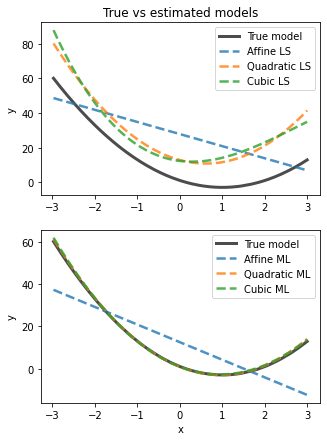

In [15]:
plt.subplots(sharex=True, figsize=(5,7))
plt.subplot(211)
plt.plot(u_sorted, y_model(u_sorted), "k-", lw=3, alpha=0.7, label="True model")
# plt.scatter(u_train, y_train, alpha=0.5, s=20, label="Training set")
# plt.scatter(u_test, y_test, alpha=0.5, s=20, label="Testing set")
# plt.scatter(u_val, y_val, alpha=0.5, s=20, label="Validation set")

plt.plot(u_sorted, affine_ls_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Affine LS")
plt.plot(u_sorted, quadratic_ls_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Quadratic LS")
plt.plot(u_sorted, cubic_ls_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Cubic LS")

plt.legend()
plt.title("True vs estimated models")
plt.ylabel("y")

plt.subplot(212)
plt.plot(u_sorted, y_model(u_sorted), "k-", lw=3, alpha=0.7, label="True model")
plt.plot(u_sorted, affine_ml_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Affine ML")
plt.plot(u_sorted, quadratic_ml_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Quadratic ML")
plt.plot(u_sorted, cubic_ml_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Cubic ML")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Comments on model order 

If we look at the performance index values from the validation set, we find that with the current $\gamma$, the cubic ML model performs marginally better than the quadratic ML, but the difference is less than 1. If we look at the parameters, though, we see that the coefficient in front of the $x^3$ term is close to zero. This indicates that the data is not strongly cubic, and that a quadratic model manages to capture the important information/trend in the data. 

The data is clearly not from a linear model when we look at the whole interval \[-3, 3\]. However, if we were to look only on e.g. \[-3, -2\] we could perhaps think that is is a linear function since it is quite linear there. In essence, is it important that we look at a large "enough" interval of data so we are sure to caputre the relevant information. Here, a case can be made that, if possible, we should look at what happens beyond $x = 3$ to get a better idea of whether the model is quadratic or cubic. 

From the plot above we see that the ML estimate has less bias than the LS estimate (considering only quadratic and cubic). 

The large sum of absolute deviation (SAD) value are large here because of the many outliers. Since the models estimate points close to the true model, if the measurement is an outlier (i.e. $y = 100$), we get large SAD values. The more outliers, the larger the SAD value. Therefore, the SAD value alone is not indicative of a good or bad model, but relative to the other values it is meaningful. 

---

Below is the performance on unseen data from the test set. We see that the cubic model performs best on this data as well. 


In [16]:
print(sum_abs_deviation(u_test, y_test, quadratic_ml))
print(sum_abs_deviation(u_test, y_test, cubic_ml))

886.7734876831208
885.1005338248419


# Varying $\gamma$

We will now look at how varying $\gamma$ will affect the performace. Even though the cubic model performed best, it was only marginally better, and since the last coefficient was close to zero, following Occam's razor principle, we should select a quadratic model. This is what we use below. 


In [17]:
import time

# acquire data
data = []
t0 = time.time()
for gamma in np.linspace(0, 1, 250):
    # generate measurements with outliers
    y_outlier_gamma = add_outliers(y_noise, gamma)

    # split into training and validation set
    M = N // 2
    u_train_gamma, y_train_gamma = u[:M], y_outlier_gamma[:M]
    u_val_gamma, y_val_gamma = u[M:], y_outlier_gamma[M:]

    # train models
    ls = least_square(u_train_gamma, y_train_gamma, 3)
    ml = maximum_likelihood(u_train_gamma, y_train_gamma, 3, pdf=laplace.pdf)

    # calculate performance
    sad_ls = sum_abs_deviation(u_val_gamma, y_val_gamma, ls)
    sad_ml = sum_abs_deviation(u_val_gamma, y_val_gamma, ml)

    data.append((
        gamma,
        ls,
        ml,
        sad_ls,
        sad_ml
    ))

t1 = time.time()
print(f"Elapsed time: {t1 - t0:.4f} seconds")


Elapsed time: 58.2964 seconds


LS value at gamma \approx 0.5: 4688.512508278056
ML value at gamma \approx 0.5: 5348.979460061779



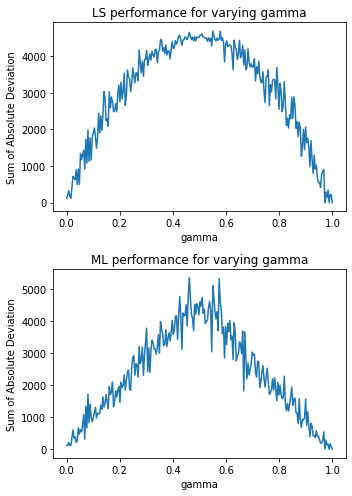

In [18]:
# split into plot-able arrays
gammas, sad_lss, sad_mls = [], [], []
for gamma, _, _, sad_ls, sad_ml in data:
    gammas.append(gamma)
    sad_lss.append(sad_ls)
    sad_mls.append(sad_ml)

print("LS value at gamma \\approx 0.5:", max(sad_lss))
print("ML value at gamma \\approx 0.5:", max(sad_mls))
print()

# plot data
plt.figure(figsize=(5,7))

plt.subplot(211)
plt.plot(gammas, sad_lss)
plt.title("LS performance for varying gamma")
plt.xlabel("gamma")
plt.ylabel("Sum of Absolute Deviation")

plt.subplot(212)
plt.plot(gammas, sad_mls)
plt.title("ML performance for varying gamma")
plt.xlabel("gamma")
plt.ylabel("Sum of Absolute Deviation")

plt.tight_layout()
plt.show()


## Comments on how $\gamma$ affect performance

We see that both estimators performs worst when there is 50/50 signal and outliers. When $\gamma < 0.5$, more measurements are of the signal than outliers, and vice versa when $\gamma > 0.5$. It is reasonable that both estimators performs worst when $\gamma = 0.5$ because then we have equally many measurements of the signal as outliers. There is therefore no good way for the algorithms of knowing which is the true signal. When $\gamma < 0.5$ most measurements pull the estimate towards the true signal, while when $\gamma > 0.5$ there are more outliers which pull the estimate towards a flat line at $y = 100$. This is the reason we get better performance again when $\gamma$ increases, because both the training and validation sets contains most outliers which then looks to be the true function. When $\gamma = 1$, we have only outliers and the models perfectly predicts this. In a certain sence, the estimate is true because we have a broken sensor, so a flat line _is_ the "true" model. 

An interesting note is the shape of the graphs above. For LS, there is a large slope in the beginning, which flattens out the closer it gets to $0.5$, and is mirrored for increasing $\gamma$'s. For ML, the slope is more or less constant up to $0.5$, and a constant fall for increasing $\gamma$'s. This means that ML degrades in a linear fashion, where a small increase in $\gamma$ leads to a small decrease in performance. On the other hand, LS has what looks like a quadratic relationship, where a small increase in $\gamma$ leads to a larger decrease in performance for small $\gamma$'s, but the decrease in performance is less impacted the more we approach 50/50 signal/outliers. 

Another interesting note is that the maximum value of the ML performance index is larger than for LS. 
